In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

from scipy.stats import norm
from scipy.optimize import curve_fit

%matplotlib inline

DEBUG = False;

# Define Gaussian function
def gaussian(x, mu, sigma,A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

Chan_dic={}
Chan_dic[0]=0
Chan_dic[1]=1
Chan_dic[3]=2
Chan_dic[4]=3
Chan_dic[5]=4


## Data

88.1383910792453 28.892882368109845 7
194.16231411216484 63.62876340402906 7
88.19935581926984 37.10928681413043 9
193.96682308671723 81.81249886890404 9
88.25832130316743 56.25921896690708 12
193.8798109397124 124.10330860044067 12
88.32850862680942 28.940141628799772 7
195.12401894557303 63.91111030713381 7
88.74402190310215 37.3279342350225 9
195.20184347191156 82.31088372722343 9


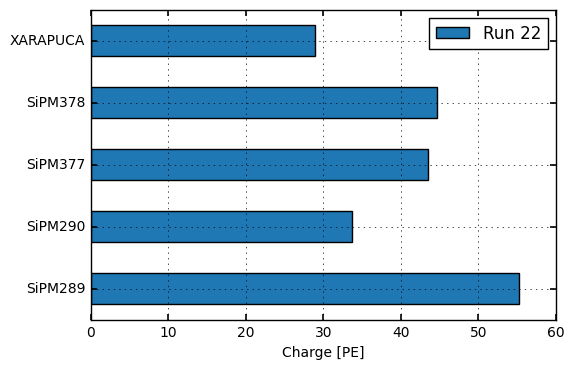

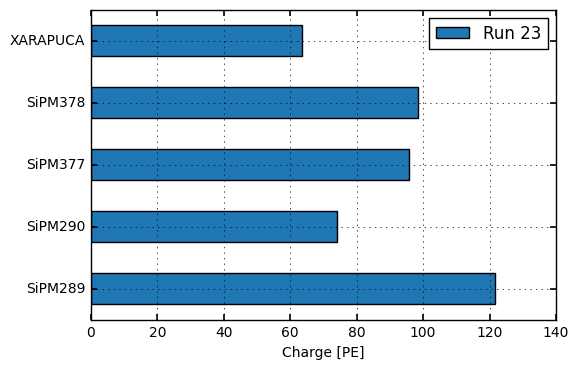

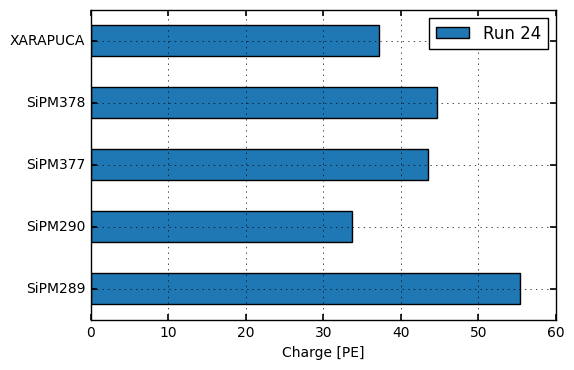

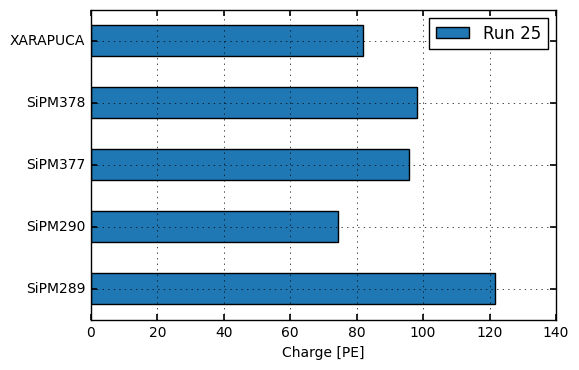

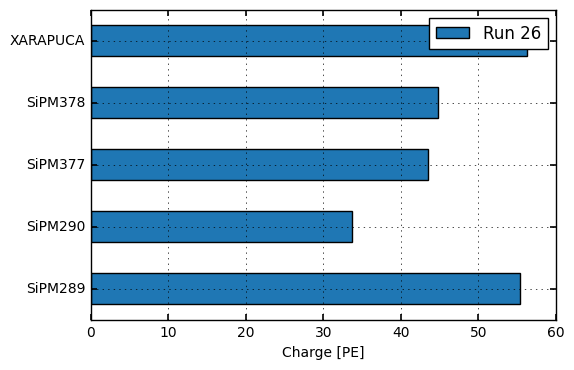

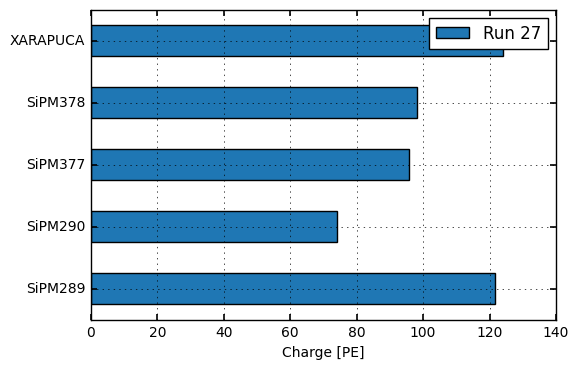

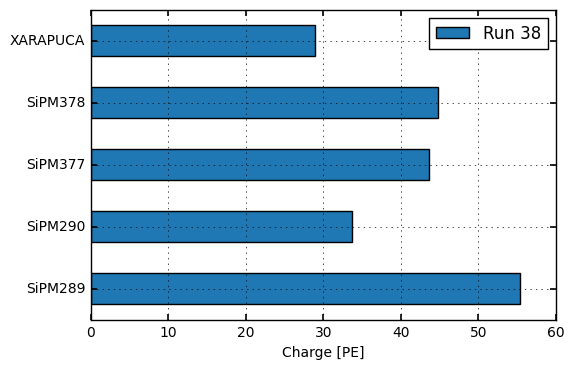

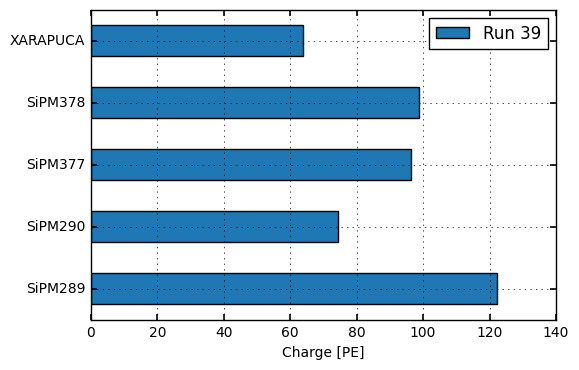

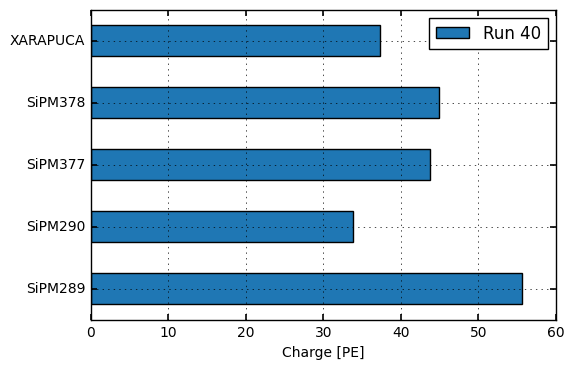

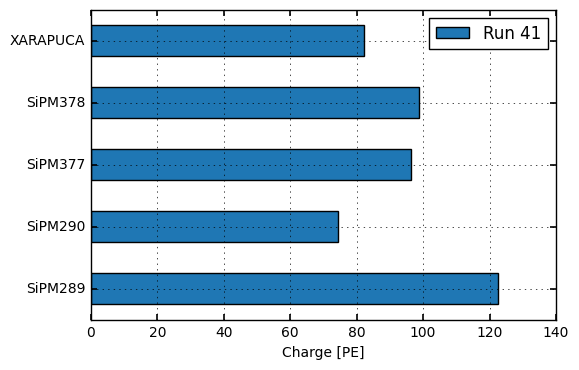

In [2]:
compress=False

# WEEK="APSAIA_VUV_2";OV=2.5
# WEEK="APSAIA_VIS";OV=2.5
# WEEK="APSAIA_VUV";#OV=3
# for OV in [2,2.5,3]:




# WEEK="DAPHNE_VIS";
WEEK="DAPHNE_VUV";

path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")

Runs=Runs[Runs["Type"]=="Visible"]
Runs

for i in range(10):
    LightRun=Runs.iloc[i]
    run=LightRun["Run"]


    plt.figure(dpi=100)
    mean=[]
    channels=[0,1,3,4,5]
    for ch in channels:
        
        if LightRun["ChannelName"][Chan_dic[ch]].__contains__("SiPM"): OV=LightRun["OverVoltageSiPMs"] 
        else:OV=LightRun["OverVoltageXA"]

        ADCsxticks2PE=GetGains(WEEK,Chan_dic[ch],OV)
        run_path=path+"run"+str(run).zfill(2)+"/";
        Charge_vars   = open_ch_var(run_path ,"Charge_vars"   ,ch,compressed=compress)
        Peak_vars     = open_ch_var(run_path  ,"Peak_vars"   ,ch,compressed=compress)
        Pedestal_vars = open_ch_var(run_path  ,"Pedestal_vars_SW"   ,ch,compressed=compress)

        #plot charge distribution from raw calibration data
        for charge in ["ChargeRangeAverageWvf"]:
            # plt.semilogy()
            Bins=100
            r=[20,160]
            
            
            

            #get counts
            # plt.hist(Charge_vars[charge]*ADCsxticks2PE,Bins,r,label="Ch "+str(ch));
            # plt.xlabel("Charge [PE]")
            # plt.ylabel("Counts")
            mean.append(np.mean(Charge_vars[charge]*ADCsxticks2PE))

    plt.barh(LightRun["ChannelName"][:len(channels)],np.array(mean),height=0.5,label="Run "+str(run).zfill(2))
    print((mean[-3]+mean[-2]),mean[-1],OV)
    plt.legend()
    plt.ylim(-0.5,4.5)
    # plt.xlim(0.5,1)
    plt.grid()
    plt.xlabel("Charge [PE]")

In [54]:
mean

[114.19621827408322,
 75.32089795674116,
 98.61741813483816,
 104.30891647027664,
 76.91616317054238]

[119.12274506 102.5861916  114.91884811 ... 136.08865608 120.65651101
 125.34175758]
[68.98753642 93.91365322 73.66348868 ... 61.49960495 60.734622
 75.73538379]
[ 99.62495917  97.01877571  95.90825205 ... 108.40532466 107.33644237
  85.99477142]
[100.22233435  91.3184758   81.05006172 ... 104.2313133   90.21495445
 100.84443446]
[63.57673684 75.10903318 52.31160814 ... 73.06472555 60.16213908
 72.06366531]


Text(0, 0.5, 'Counts')

<Figure size 600x400 with 0 Axes>

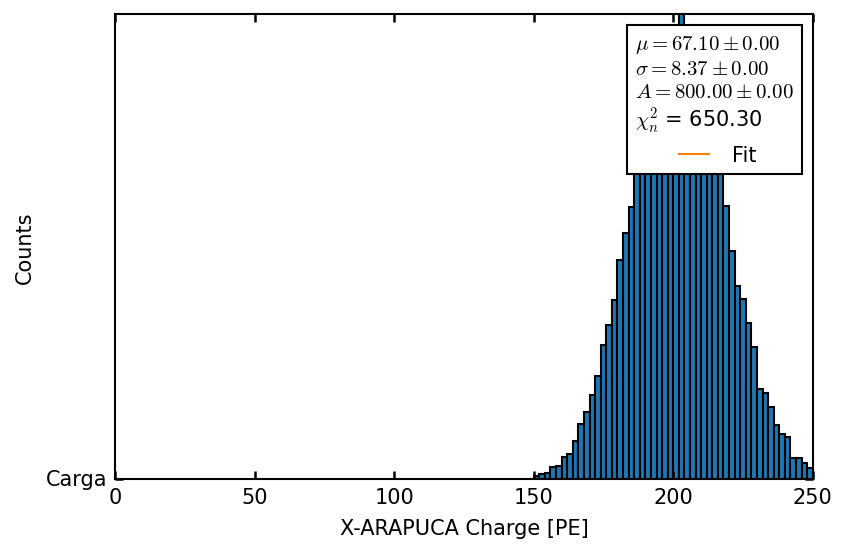

In [10]:
from lmfit.models import GaussianModel
from iminuit import cost
from iminuit import Minuit
from numba_stats import norm, t
from jacobi import propagate
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal   import find_peaks

# Define Gaussian function
def gaussian(x, mu, sigma,A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


WEEK="APSAIA_VUV";#OV=3
# for OV in [2,2.5,3]:




# WEEK="DAPHNE_VIS";
# WEEK="DAPHNE_VUV";

compress=False

path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")

Runs=Runs[Runs["Type"]=="Visible"]
Runs

Q=[]
for i in range(1):
    LightRun=Runs.iloc[i]
    run=LightRun["Run"]


    plt.figure(dpi=100)
    mean=[]
    channels=[0,1,3,4,5]
    for ch in channels:
        
        if LightRun["ChannelName"][Chan_dic[ch]].__contains__("SiPM"): OV=LightRun["OverVoltageSiPMs"] 
        else:OV=LightRun["OverVoltageXA"]

        ADCsxticks2PE=GetGains(WEEK,Chan_dic[ch],OV)
        run_path=path+"run"+str(run).zfill(2)+"/";
        Charge_vars   = open_ch_var(run_path ,"Charge_vars"   ,ch,compressed=compress)
        Peak_vars     = open_ch_var(run_path  ,"Peak_vars"   ,ch,compressed=compress)
        Pedestal_vars = open_ch_var(run_path  ,"Pedestal_vars_SW"   ,ch,compressed=compress)

        #plot charge distribution from raw calibration data
        for charge in ["ChargeRangeAverageWvf"]:
            # plt.semilogy()
            Bins=100
            r=[20,160]
            
            q_PEs=Charge_vars[charge]*ADCsxticks2PE
            print(q_PEs)
            Q.append(np.array(q_PEs))
            mean.append(np.mean(q_PEs))


plt.figure(dpi=150)


data=Q[-2]+Q[-3]
Bins=50
R   =[150,250]
counts,bins=np.histogram(data,Bins,R)
plt.hist(data,Bins,R)
ydata=counts
xdata=bins[:-1]+(bins[1]-bins[0])/2
c = cost.LeastSquares(xdata, ydata, np.sqrt(ydata), gaussian)
m = Minuit(c, *(mean[-1],np.std(Q[-1]),800))
m.migrad()
plt.plot(xdata, gaussian(xdata, *m.values), label="Fit")
m.hesse()
# plt.legend()
plt.legend(    frameon=True,       title=f"$\mu = {m.values[0]:.2f} \pm {m.errors[0]:.2f}$\n"
                 f"$\sigma = {m.values[1]:.2f} \pm {m.errors[1]:.2f}$\n"
                 f"$A = {m.values[2]:.2f} \pm {m.errors[2]:.2f}$\n"
                 f'$\chi^2_n $ = {m.fval/m.ndof:.2f}'
         ,fontsize=10);
# Errorbands
# y, ycov = propagate(lambda p: gaussian(xdata,  *p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
# plt.fill_between(xdata, y - yerr_prop*5, y + yerr_prop*5, alpha=0.2,color="tab:orange")
# plt.plot(xdata, y - yerr_prop*5, alpha=0.5,color="tab:orange")
# plt.plot(xdata, y + yerr_prop*5, alpha=0.5,color="tab:orange")
plt.plot("Carga")
plt.xlabel("X-ARAPUCA Charge [PE]")
plt.ylabel("Counts")


## Check SiPM diffuser cosine law holds

In [51]:
#aprox 

#front

z=83.5
sipm_distance=12.7
x=sipm_distance/2
y=0
r_front=np.sqrt(x**2+y**2+z**2)
theta=np.arccos(z/r_front)*180/np.pi

# lateral

z=49-8.7
z1=z+sipm_distance/2
z2=z-sipm_distance/2
x=26
r_lat1=np.sqrt(x**2+z1**2)
r_lat2=np.sqrt(x**2+z2**2)
theta1=np.arccos(z1/r_lat1)*180/np.pi
theta2=np.arccos(z2/r_lat2)*180/np.pi
print("theta","theta1,theta2")
print(theta,theta1,theta2)
print()
print("90-theta1,90-theta2")
print(90-theta1,90-theta2)
print()
print("r_front,r_lat1,r_lat2")
print(r_front,r_lat1,r_lat2)
print()
print("cos(theta1),cos(theta2)")
print(np.cos(theta1*np.pi/180),np.cos(theta2*np.pi/180))
print()
print("cos(90-theta1),cos(90-theta2)")
print(np.cos((90-theta1)*np.pi/180),np.cos((90-theta2)*np.pi/180))
print()
ratio_front_1=r_front**2/r_lat1**2 *(np.cos(theta1*np.pi/180))*(np.cos((90-theta1)*np.pi/180)) /np.cos(theta*np.pi/180)
ratio_front_2=r_front**2/r_lat2**2 *(np.cos(theta2*np.pi/180))*(np.cos((90-theta2)*np.pi/180)) /np.cos(theta*np.pi/180)

print("ratio_front_1,ratio_front_2")
print(ratio_front_1,ratio_front_2)
print()
#closest SiPM as reference:
SiPM1=1
SiPM34=1/ratio_front_2
SiPM5=ratio_front_1/ratio_front_2

print("SiPM1,SiPM34,SiPM5")
print(SiPM1,SiPM34,SiPM5)

theta theta1,theta2
4.348853290332962 29.132755973197128 37.44605187308574

90-theta1,90-theta2
60.86724402680287 52.55394812691426

r_front,r_lat1,r_lat2
83.74110400514195 53.406202823267634 42.762162012695285

cos(theta1),cos(theta2)
0.8734940425248855 0.7939261815134809

cos(90-theta1),cos(90-theta2)
0.4868348361339126 0.6080141596274082

ratio_front_1,ratio_front_2
1.048546666573482 1.8565390099879477

SiPM1,SiPM34,SiPM5
1 0.5386366753513527 0.5647856904338837


In [96]:
# Analitic (suposse point like source)

def solid_angle(x,y,z):#VUV case
    return np.arctan(x*y/(z*np.sqrt(x**2 + y**2 + z**2)))

def solid_angle_cos(x,y,z):
    #Solid angle weighted by cos(theta) (difuser): ONLY FOR VISIBLE LIGHT
    return -((z*np.arctan (y/np.sqrt(x**2 + z**2)))/(2 *np.sqrt(x**2 + z**2)))

def double_integral_evaluation(function,x0,x1,y0,y1,z):
    return (function(x1, y1, z) - function(x1, y0, z) - function(x0, y1, z) + function(x0, y0, z))

# SiPMs

# In front of the laser: SiPMs 3 and 4
# all in mm
SiPM_side=6
SiPM_sepparation=12.7
x0     = SiPM_sepparation/2-SiPM_side/2
x1     = SiPM_sepparation/2+SiPM_side/2
y0     = -SiPM_side/2
y1     = SiPM_side/2
z = 83.5

Cos=z /np.sqrt(SiPM_sepparation**2/4+z**2)

SiPM_3_4_solid_angle = double_integral_evaluation(solid_angle,x0,x1,y0,y1,z)*Cos

print("Solid angle for SiPMs in front of the laser: ",SiPM_3_4_solid_angle)




Solid angle for SiPMs in front of the laser:  0.005097671095842242


<BarContainer object of 36 artists>

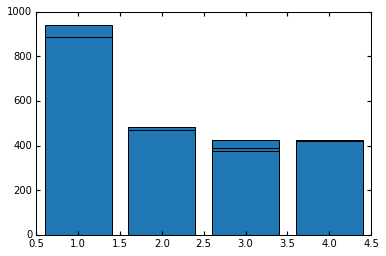

In [9]:
import uproot
file=uproot.open("GEANT4_Vis.root")
Ps=file['Hits']["acumHits"].array()
Ch=file['Hits']["fsensor"] .array()

Ps=Ps[~ (Ch==0)]
Ch=Ch[~ (Ch==0)]
plt.bar(Ch,Ps)
# plt.semilogy()
# plt.xlim(1,5)